The dataset consists of proeotmics from 3 bones

1. skull (calvaria)
2. vertebra
3. pelvis

for 5 human samples

total 15 measurements.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random 

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import anndata as ann

sc.settings.set_figure_params(dpi=100)


from utils import (
                    get_genes_per_group,                
                    filter_proteins_per_group, 
                    normalise,
                    impute_knn,
                    impute_knn_nan,
                    impute_min_value,
                    impute_min_value_nan,
                  )

from gprofiler import GProfiler
from gprofiler_plotting import plot_enrich, plot_gene_enrichment

from bioinfokit import analys, visuz

In [3]:
DATA_DIR = ""
FILE_NAME = ""

In [4]:
adata = sc.read(f"{DATA_DIR}/{FILE_NAME}")

In [7]:
# setting same colors as in previous manuscript
_color_Pelvis = '#aa40fc'
_color_Calvaria = '#e377c2'
_color_Vertebra = '#76b947'

adata.uns["region_colors"] = [_color_Calvaria, _color_Pelvis, _color_Vertebra]

In [8]:
adata

AnnData object with n_obs × n_vars = 60 × 5320
    obs: 'sample', 'region', 'region_sample', 'age', 'cause_of_death', 'pmi', 'sex'
    var: 'gene', 'protein_id', 'protein_names', 'n_cells'
    uns: 'neighbors', 'pca', 'region_colors', 'sample_colors', 'sex_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
# adding groups of causes of death
cause_of_death_dict = {
'Polytrauma (Accident)': "traumatic",
'Myocardial infarction': "hypoxic",
'Head shot (Suicide) possible M.Parkinson': "traumatic",
'Hanging (suicide)': "hypoxic",
'Pneumonia': "hypoxic",
'Pulmonary thromboembolism': "hypoxic",
'Bypass-Thrombosis': "hypoxic",
'Acute myocardial infarction': "hypoxic",
'Hypothermia': "other",
'Acute heart failure': "hypoxic",
'Intoxication': "other",
'Traumatic brain injury ': "traumatic",
'Intracerebral bleeding': "traumatic",
'Asphyxiaton (Hanging/suicide)': "hypoxic",
'Dissection of aorta (Traffic accident)': "hypovolemic",
'Asphyxiaton (possible anaphylactic shock)': "hypoxic",
'Hemorrhagic shock (Suicide)': "hypovolemic",
'Hemorrhagic shock (complication during central venous cathederization)': "hypovolemic",


}
cause_of_death_group=np.array([])

for c in adata.obs["cause_of_death"]:
    cause_of_death_group = np.append(cause_of_death_group, cause_of_death_dict[c])
    
adata.obs["cause_of_death_group"] = cause_of_death_group
adata.obs["cause_of_death_group"] = adata.obs["cause_of_death_group"].astype('category')

In [ ]:
# adding age groups

age_group = np.array([])
young_age = "21-40"
middle_age = "41-60"
upper_middle_age = "61-80"
old_age = "81+"
for a in adata.obs["age"]:
    if a <= 40:
        age_group = np.append(age_group, young_age)
    elif a <= 60:
        age_group = np.append(age_group, middle_age)
    elif a <= 80:
        age_group = np.append(age_group, upper_middle_age)
    else:
        age_group = np.append(age_group, old_age)
adata.obs["age_group"] = age_group
adata.obs["age_group"] = adata.obs["age_group"].astype('category')

In [12]:
adata_skull = adata[adata.obs["region"] == "Skull"]

#### Downstream analysis

In [14]:
region_to_color = {
    "Calvaria"  : "#e377c2",
    "Brain"     : "#1f77b4",
    "Femur"     : "#ff7f0e",
    "Humerus"   : "#279e68",
    "Meninges"  : "#d62728",
    "Pelvis"    : "#aa40fc",
    "Scapula"   : "#8c564b",
    "Vertebra"  : "#b5bd61",
}
_color_Pelvis = region_to_color["Pelvis"]
_color_Calvaria = region_to_color["Calvaria"]
_color_Vertebra = region_to_color["Vertebra"]

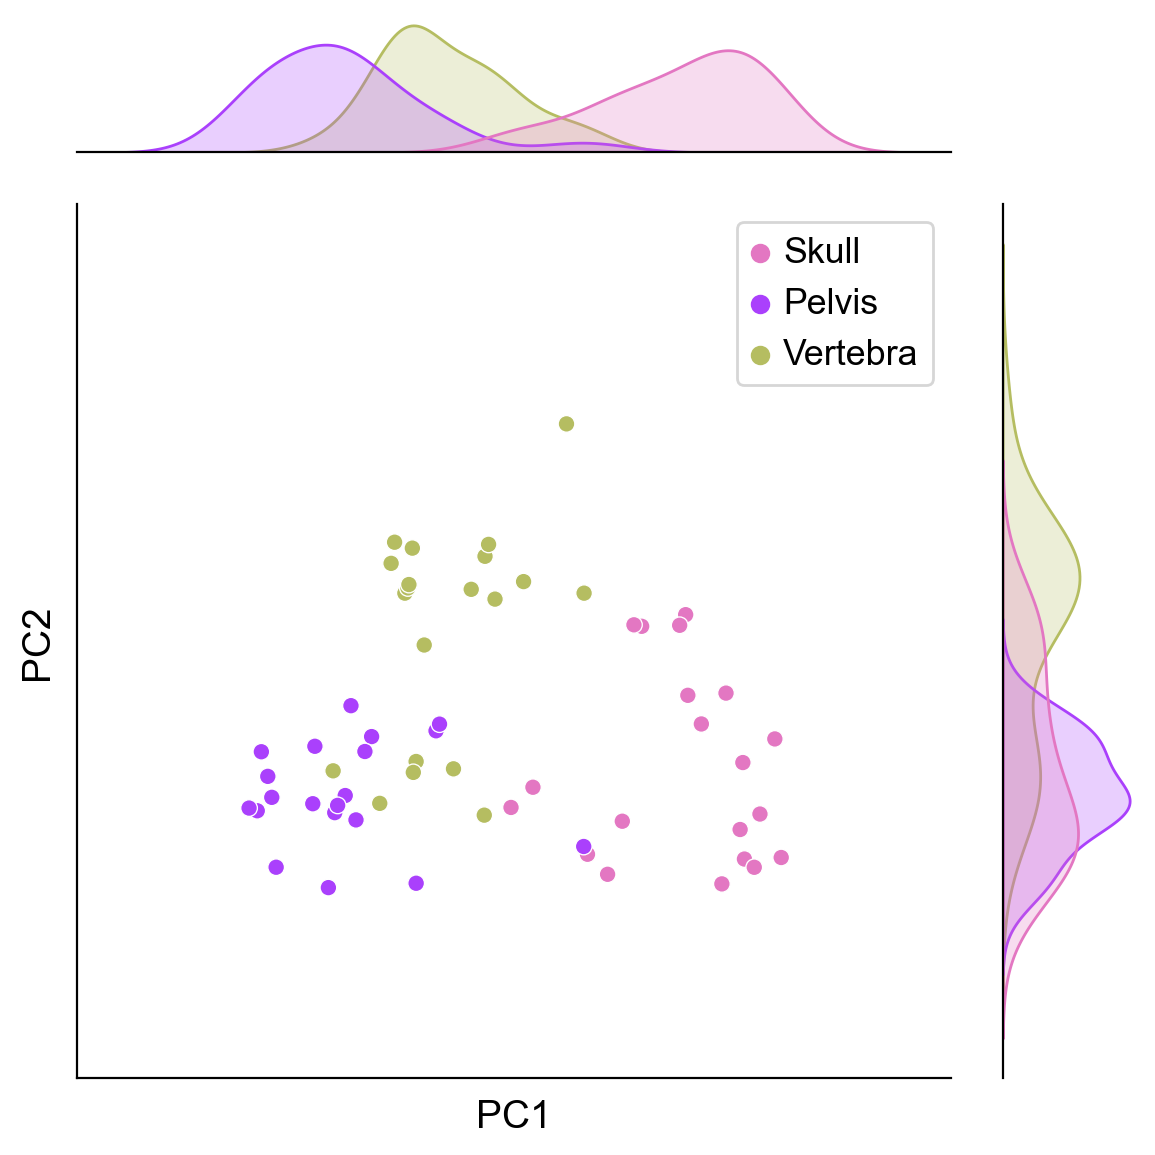

In [15]:
g = sns.jointplot(
    x=adata.obsm["X_pca"][:,0], 
    y=adata.obsm["X_pca"][:,1],
    hue=adata.obs["region"].values,
    palette=[_color_Calvaria, _color_Pelvis, _color_Vertebra]
            )
g.ax_joint.set_xticks([])
g.ax_joint.set_yticks([])
g.ax_joint.set_xlabel('PC1')
g.ax_joint.set_ylabel('PC2')

plt.tight_layout()
plt.savefig("figures/final_colours/pca_bones_20donors.pdf")
plt.show()

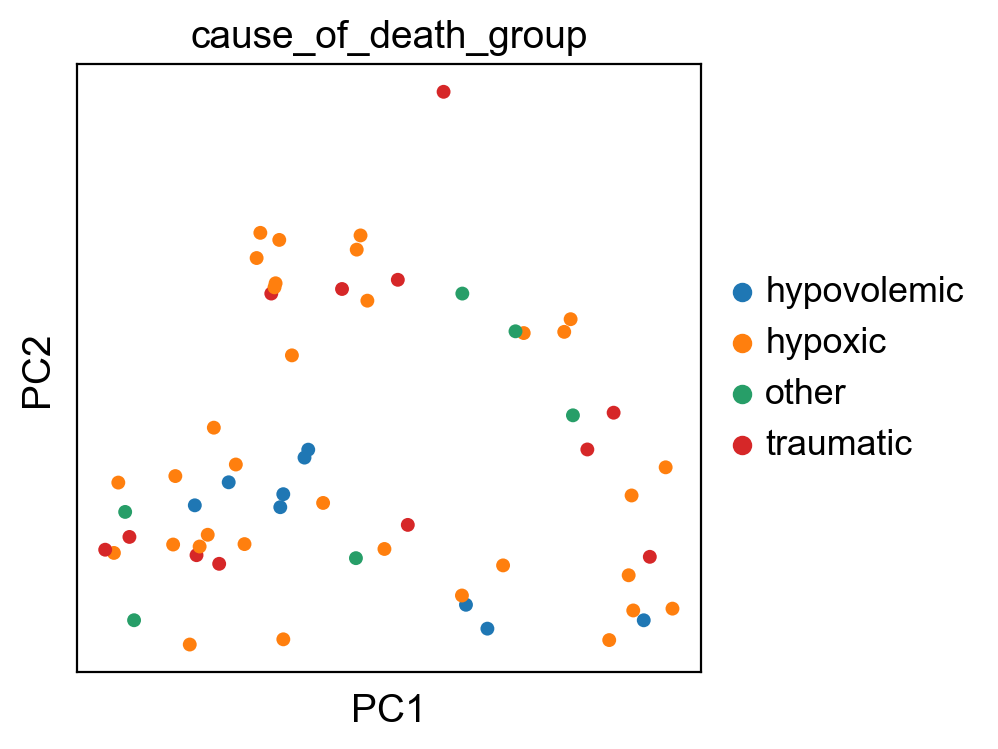

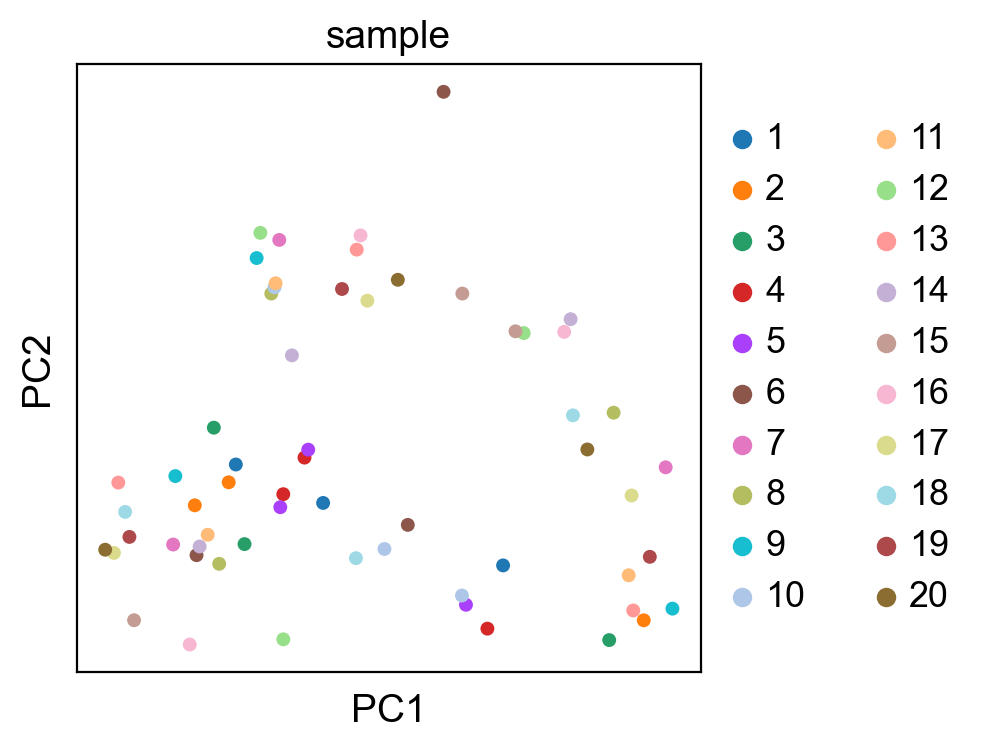

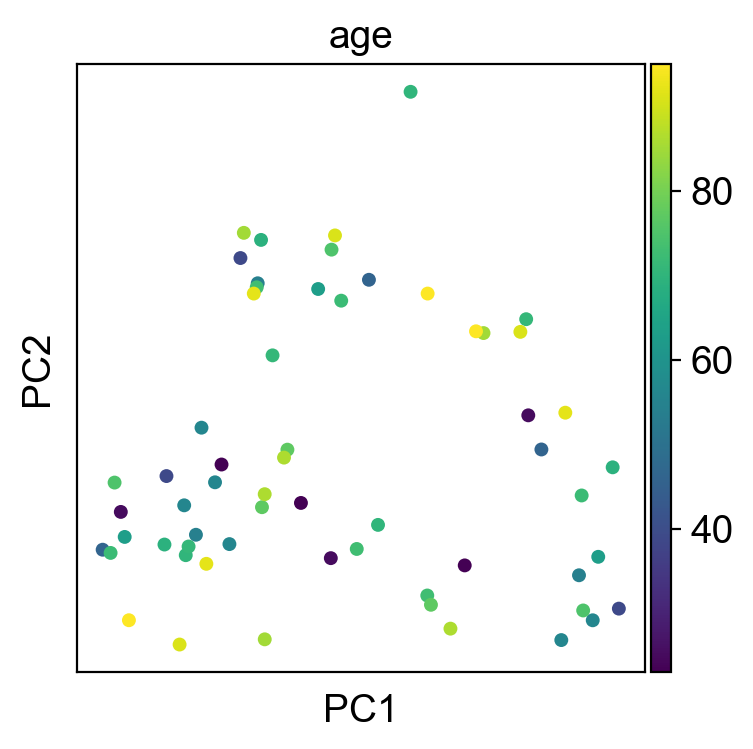

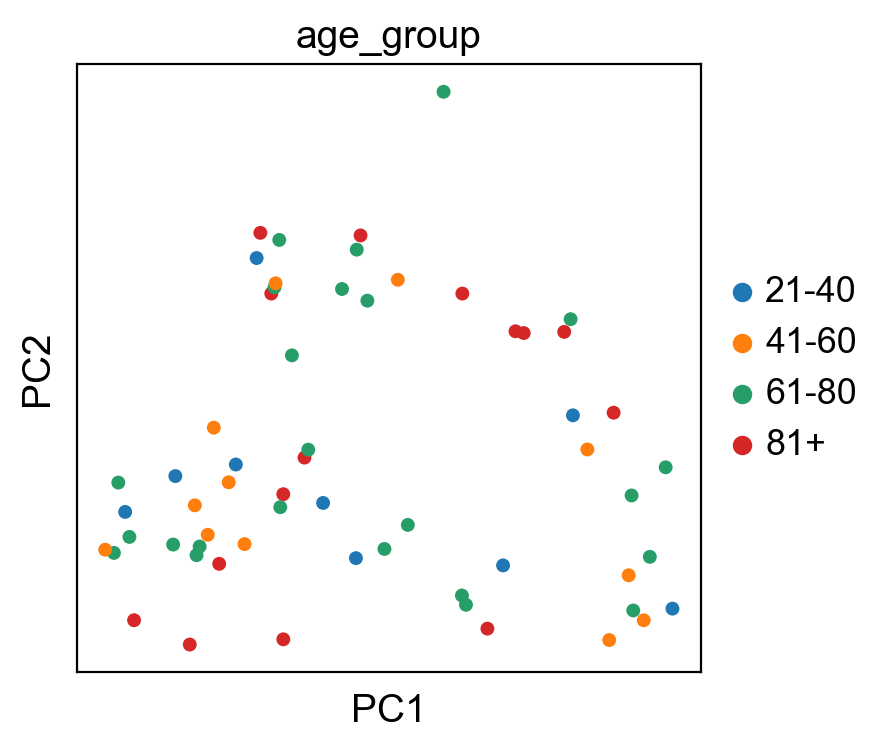

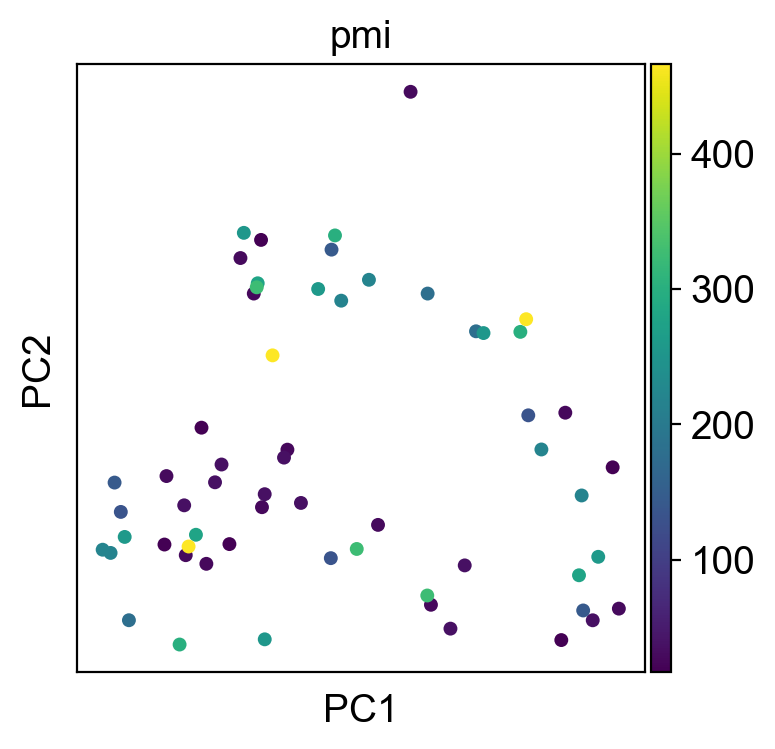

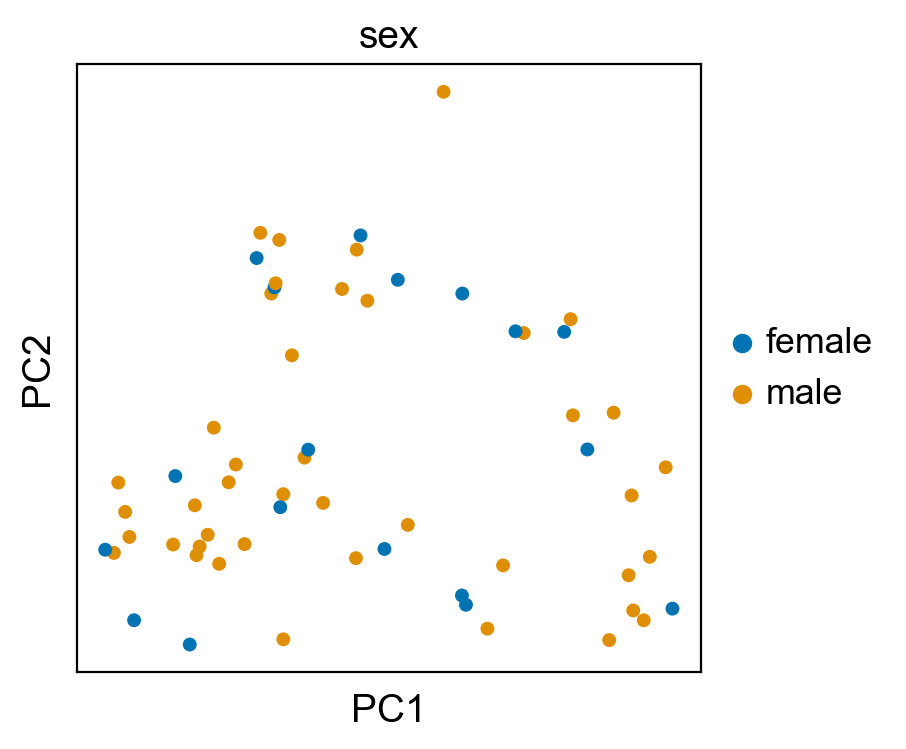

In [16]:
sc.pl.pca(adata, color="cause_of_death_group", size=100, save="_cause_of_death_20donors.pdf")
sc.pl.pca(adata, color="sample", size=100, save="_sample_20donors.pdf")
sc.pl.pca(adata, color="age", size=100, save="_age_20donors.pdf")
sc.pl.pca(adata, color="age_group", size=100, save="_age_group_20donors.pdf")
sc.pl.pca(adata, color="pmi", size=100, save="_pmi_20donors.pdf")
sc.pl.pca(adata, color="sex", size=100, save="_sex_20donors.pdf")

In [14]:
def _eucledian_distance(point_a, point_b):
    temp = point_a - point_b
    sum_sq = np.dot(temp.T, temp)

    # Doing squareroot and
    # printing Euclidean distance
    return np.sqrt(sum_sq)

In [15]:

idx_calvaria = np.where(adata.obs["region"] == "Skull")[0]
idx_vertebra = np.where(adata.obs["region"] == "Vertebra")[0]
idx_pelvis = np.where(adata.obs["region"] == "Pelvis")[0]    

df = pd.DataFrame()
samples = np.array([])
dist = np.array([])
bone_bone = np.array([])
for sample in adata.obs["sample"].unique():
    idx_sample = np.where(adata.obs["sample"] == sample)[0]
    
    i_calvaria = list(set(idx_sample) & set(idx_calvaria))[0]
    i_vertebra = list(set(idx_sample) & set(idx_vertebra))[0]
    i_pelvis = list(set(idx_sample) & set(idx_pelvis))[0]

    
    calvaria_pt = np.array([adata.obsm["X_pca"][i_calvaria,0], adata.obsm["X_pca"][i_calvaria,1]])
    vertebra_pt = np.array([adata.obsm["X_pca"][i_vertebra,0], adata.obsm["X_pca"][i_vertebra,1]])
    pelvis_pt = np.array([adata.obsm["X_pca"][i_pelvis,0], adata.obsm["X_pca"][i_pelvis,1]])
    
    samples = np.append(samples, sample)
    samples = np.append(samples, sample)
    samples = np.append(samples, sample)
    dist = np.append(dist, _eucledian_distance(calvaria_pt, vertebra_pt))
    bone_bone = np.append(bone_bone, "skull-vertebra")
    dist = np.append(dist, _eucledian_distance(calvaria_pt, pelvis_pt))
    bone_bone = np.append(bone_bone, "skull-pelvis")
    dist = np.append(dist, _eucledian_distance(vertebra_pt, pelvis_pt))
    bone_bone = np.append(bone_bone, "vertebra-pelvis")
    
df["sample"] = samples
df["dist"] = dist
df["bone-bone"] = bone_bone


In [16]:
from statannot import add_stat_annotation

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

skull-pelvis v.s. vertebra-pelvis: t-test paired samples with Bonferroni correction, P_val=2.862e-04 stat=4.738e+00
skull-vertebra v.s. vertebra-pelvis: t-test paired samples with Bonferroni correction, P_val=1.578e-01 stat=1.857e+00


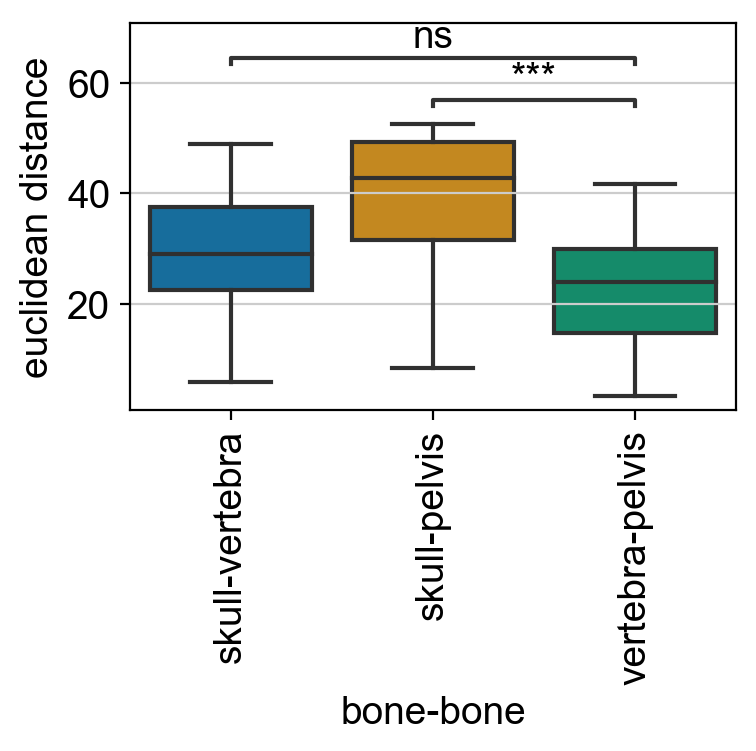

In [17]:
x="bone-bone"
y="dist"

ax = plt.gca()

sns.boxplot(data=df, x=x, y=y, ax=ax)
add_stat_annotation(ax, data=df, x=x, y=y, 
                   box_pairs=[("skull-vertebra", "vertebra-pelvis"), 
                              ("skull-pelvis", "vertebra-pelvis")],
                   test='t-test_paired', text_format='star',
                   loc='inside', verbose=2)
plt.xticks(rotation=90)
plt.ylabel('euclidean distance')
plt.tight_layout()
plt.savefig("figures/final/bone-bone_distance_20donors.pdf")
plt.show()

In [20]:
adata.obs["region_sample"] = adata.obs["region_sample"].astype('category')

In [21]:
adata.obs["age_category"] = adata.obs["age"].astype('category')
adata.obs["pmi_category"] = adata.obs["pmi"].astype('category')

In [22]:
adata.obs["sample_death"] = adata.obs["sample"].astype(str) + "_" + adata.obs["cause_of_death_group"].astype(str)
adata.obs["sample_death"] = adata.obs["sample_death"].astype('category')

adata.obs["region_age_group"] = adata.obs["region"].astype(str) + "_" + adata.obs["age_group"].astype(str)
adata.obs["region_age_group"] = adata.obs["region_age_group"].astype('category')

In [17]:
def rank_genes_groups_df(adata, group, pval_cutoff : float =None, logfc_cutoff=None): 
    d = pd.DataFrame() 
    for k in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']: 
        d[k] = adata.uns["rank_genes_groups"][k][group] 
    if pval_cutoff is not None: 
        d = d[d["pvals_adj"] < pval_cutoff] 
    if logfc_cutoff is not None: 
        d = d[d["logfoldchanges"].abs() > logfc_cutoff] 
    return d

def get_de_genes(adata, groupby, ref_group, n_genes, pval_threshold=0.05, logfoldchanges_threshold=0.5):
    sc.tl.rank_genes_groups(adata, groupby=groupby, n_genes=n_genes)
    de_df = rank_genes_groups_df(adata, ref_group)
    de_df['diffexpressed'] = np.full(len(de_df), "NO")

    if logfoldchanges_threshold:
        de_df.loc[(de_df['logfoldchanges'] > logfoldchanges_threshold) & (de_df['pvals'] < pval_threshold), 'diffexpressed'] = 'UP'
        de_df.loc[(de_df['logfoldchanges'] < -logfoldchanges_threshold) & (de_df['pvals'] < pval_threshold), 'diffexpressed'] = 'DOWN'
    else:
        de_df.loc[(de_df['pvals'] < pval_threshold), 'diffexpressed'] = 'YES'
        return  de_df, de_df[de_df['diffexpressed'] == 'YES']["names"].values
    de_up = de_df[de_df['diffexpressed'] == 'UP']["names"].values
    de_down = de_df[de_df['diffexpressed'] == 'DOWN']["names"].values
    return de_df, de_up, de_down

In [18]:
LOGFOLDCHANGE_THRESHOLD=1

In [19]:
# adapted from https://github.com/reneshbedre/bioinfokit/blob/master/bioinfokit/visuz.py
from matplotlib.colors import ListedColormap
def volcano(df="dataframe", lfc=None, pv=None, lfc_thr=(1, 1), pv_thr=(0.05, 0.05), color=("green", "grey", "red"),
                valpha=1, geneid=None, genenames=None, gfont=8, dim=(5, 5), r=300, ar=90, dotsize=8, markerdot="o",
                sign_line=False, gstyle=1, show=False, figtype='png', title=None, axtickfontsize=9,
                axtickfontname="Arial", axlabelfontsize=9, axlabelfontname="Arial", axxlabel=None,
                axylabel=None, xlm=None, ylm=None, plotlegend=False, legendpos='best',
                figname='volcano', legendanchor=None,
                legendlabels=['significant up', 'not significant', 'significant down'], save=None, theme=None):
        _x = r'$ log_{2}(Fold Change)$'
        _y = r'$ -log_{10}(P-value)$'
        color = color
        # check if dataframe contains any non-numeric character
        #assert general.check_for_nonnumeric(df[lfc]) == 0, 'dataframe contains non-numeric values in lfc column'
        #assert general.check_for_nonnumeric(df[pv]) == 0, 'dataframe contains non-numeric values in pv column'
        # this is important to check if color or logpv exists and drop them as if you run multiple times same command
        # it may update old instance of df
        df = df.drop(['color_add_axy', 'logpv_add_axy'], axis=1, errors='ignore')
        assert len(set(color)) == 3, 'unique color must be size of 3'
        df.loc[(df[lfc] >= lfc_thr[0]) & (df[pv] < pv_thr[0]), 'color_add_axy'] = color[0]  # upregulated
        df.loc[(df[lfc] <= -lfc_thr[1]) & (df[pv] < pv_thr[1]), 'color_add_axy'] = color[2]  # downregulated
        df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate
        df['logpv_add_axy'] = -(np.log10(df[pv]))
        # plot
        assign_values = {col: i for i, col in enumerate(color)}
        color_result_num = [assign_values[i] for i in df['color_add_axy']]
        assert len(set(color_result_num)) == 3, \
            'either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include ' \
            'both significant and non-significant genes'
        if theme == 'dark':
            general.dark_bg()
        plt.subplots(figsize=dim)
        if plotlegend:
            s = plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                            s=dotsize, marker=markerdot)
            assert len(legendlabels) == 3, 'legendlabels must be size of 3'
            plt.legend(handles=s.legend_elements()[0], labels=legendlabels, loc=legendpos, bbox_to_anchor=legendanchor)
        else:
            plt.scatter(df[lfc], df['logpv_add_axy'], c=color_result_num, cmap=ListedColormap(color), alpha=valpha,
                        s=dotsize, marker=markerdot)
        if sign_line:
            plt.axhline(y=-np.log10(pv_thr[0]), linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=lfc_thr[0], linestyle='--', color='#7d7d7d', linewidth=1)
            plt.axvline(x=-lfc_thr[1], linestyle='--', color='#7d7d7d', linewidth=1)
        if title:
            plt.title(title)
        if save:
            plt.savefig(save)

In [26]:
def rank_genes_groups_df(adata, group, pval_cutoff : float =None, logfc_cutoff=None): 
    d = pd.DataFrame() 
    for k in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']: 
        d[k] = adata.uns["rank_genes_groups"][k][group] 
    if pval_cutoff is not None: 
        d = d[d["pvals_adj"] < pval_cutoff] 
    if logfc_cutoff is not None: 
        d = d[d["logfoldchanges"].abs() > logfc_cutoff] 
    return d

def get_de_genes(adata, 
                 groupby, 
                 ref_group, 
                 n_genes, 
                 pval_threshold=0.05, 
                 logfoldchanges_threshold=0.5,
                 pval_col='pvals_adj'
                ):
    sc.tl.rank_genes_groups(adata, groupby=groupby, n_genes=n_genes)
    de_df = rank_genes_groups_df(adata, ref_group)
    de_df['diffexpressed'] = np.full(len(de_df), "NO")

    if logfoldchanges_threshold:
        de_df.loc[(de_df['logfoldchanges'] > logfoldchanges_threshold) & (de_df[pval_col] < pval_threshold), 'diffexpressed'] = 'UP'
        de_df.loc[(de_df['logfoldchanges'] < -logfoldchanges_threshold) & (de_df[pval_col] < pval_threshold), 'diffexpressed'] = 'DOWN'
    else:
        de_df.loc[(de_df[pval_col] < pval_threshold), 'diffexpressed'] = 'YES'
        return  de_df, de_df[de_df['diffexpressed'] == 'YES']["names"].values
    de_up = de_df[de_df['diffexpressed'] == 'UP']["names"].values
    de_down = de_df[de_df['diffexpressed'] == 'DOWN']["names"].values
    return de_df, de_up, de_down

In [27]:
def plot_volcano(adata, 
                 groupby, 
                 ref_group, 
                 logfoldchanges_threshold=None, 
                 pval_col='pvals',
                 plot_volcano=True,
                 title='',
                 save_fig=None,
                 save_de_genes=None,
                 return_de=False,
                ):
    de_df, de_genes = get_de_genes(
        adata=adata, 
        groupby=groupby, 
        ref_group=ref_group,
        n_genes=adata.var_names.size,
        logfoldchanges_threshold=logfoldchanges_threshold,
        pval_col=pval_col
    )
    print(f'There are {len(np.unique(de_genes))} genes differentially expressed in {ref_group} vs rest.')
    print()
    de_df_sig = de_df[de_df["diffexpressed"] == "YES"]
    
    de_df_up = de_df_sig[de_df_sig["logfoldchanges"] > LOGFOLDCHANGE_THRESHOLD]
    de_df_down = de_df_sig[de_df_sig["logfoldchanges"] < -LOGFOLDCHANGE_THRESHOLD]
    print(f'There are {len(de_df_up)} genes differentially up regulated')
    print(f'There are {len(de_df_down)} genes differentially down regulated')
    
    
    # plot volcano
    if plot_volcano:
        fig = volcano(df=de_df, 
                 lfc='logfoldchanges', 
                 pv='pvals', 
                 show=True, 
                 dotsize=2,
                 geneid="names", 
                 lfc_thr=(LOGFOLDCHANGE_THRESHOLD, LOGFOLDCHANGE_THRESHOLD),
                 sign_line=True,
                 color=("#E10600FF", "grey", "#00239CFF"), 
                 plotlegend=True, 
                 axtickfontname='sans-serif',
                 axlabelfontname='sans-serif',
                 legendpos='upper right', 
                 legendanchor=(1.55,1.025),
                 title=title,
                 save=save_fig,
            )
        
    if save_de_genes:
        df = pd.DataFrame()
        df["genes"] = de_df_up["names"].tolist() + de_df_down["names"].tolist()
        df["diffexpressed"] = np.append(np.full(len(de_df_up["names"].tolist()), "UP"),
                                        np.full(len(de_df_down["names"].tolist()), "DOWN"))
        df.to_csv(save_de_genes)
    
    if return_de:
        return de_df_sig, de_df_down, de_df_up

In [28]:
pvals_col='pvals'

In [29]:
RESULTS_DIR=""
SAVE_DIR=""

Skull vs rest
There are 4324 genes differentially expressed in Skull vs rest.

There are 37 genes differentially up regulated
There are 368 genes differentially down regulated


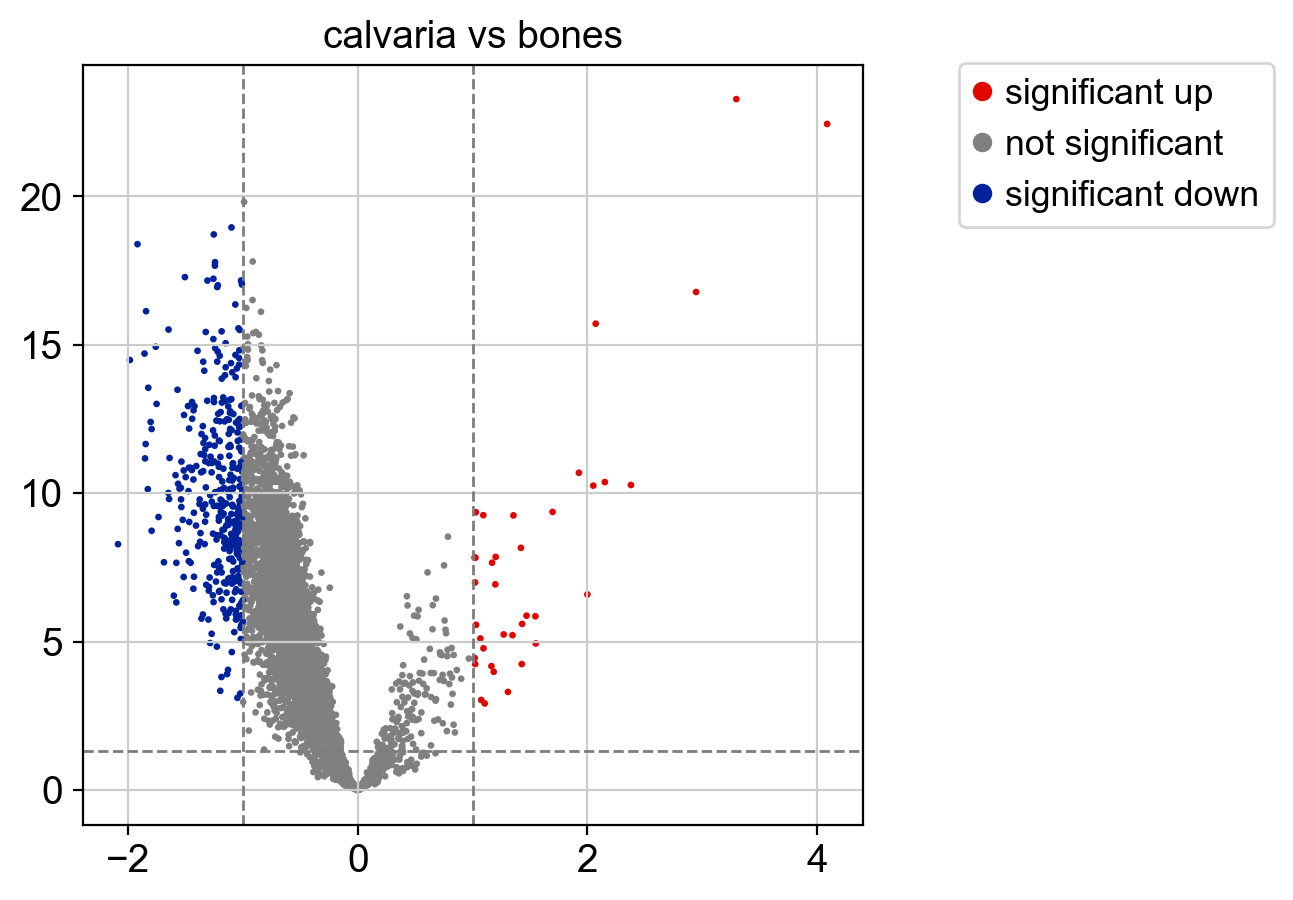

In [34]:
bone="Skull"
print('Skull vs rest')

groupby="region"
ref_group="Skull"
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title='calvaria vs bones',
    save_fig=f"{SAVE_DIR}/{bone}/de_genes_{bone}_vs_bones.pdf",
    save_de_genes=f"{RESULTS_DIR}/{bone}/de_genes_{bone}_vs_bones.csv",
    return_de=True,
)

calvaria vs bones 
------------------


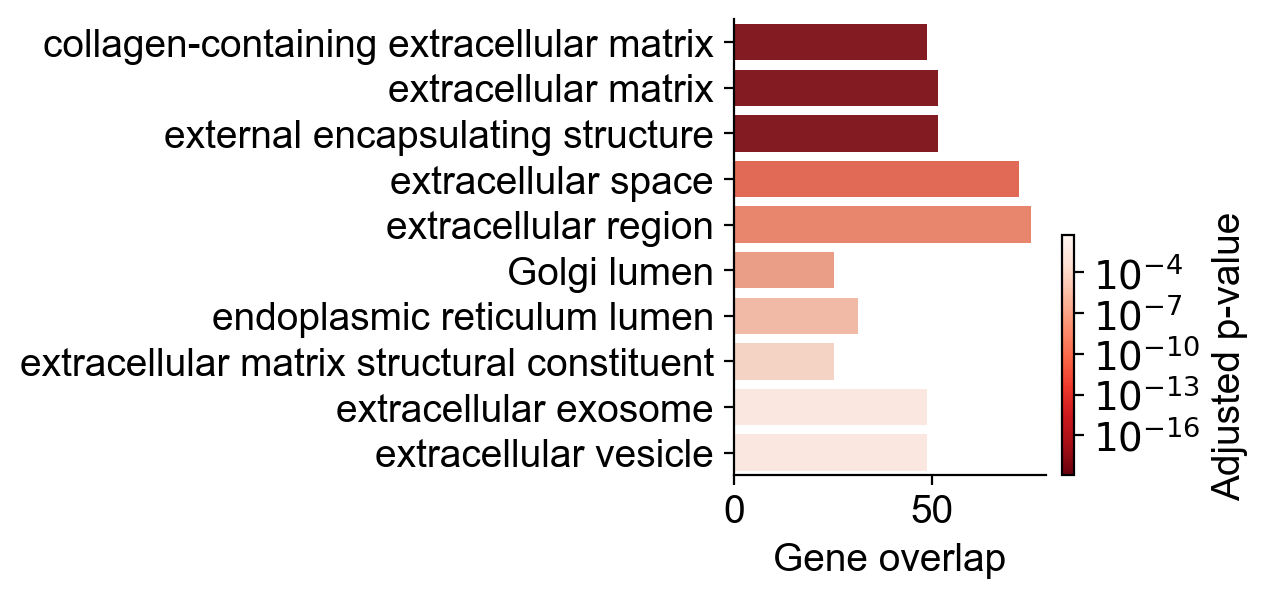

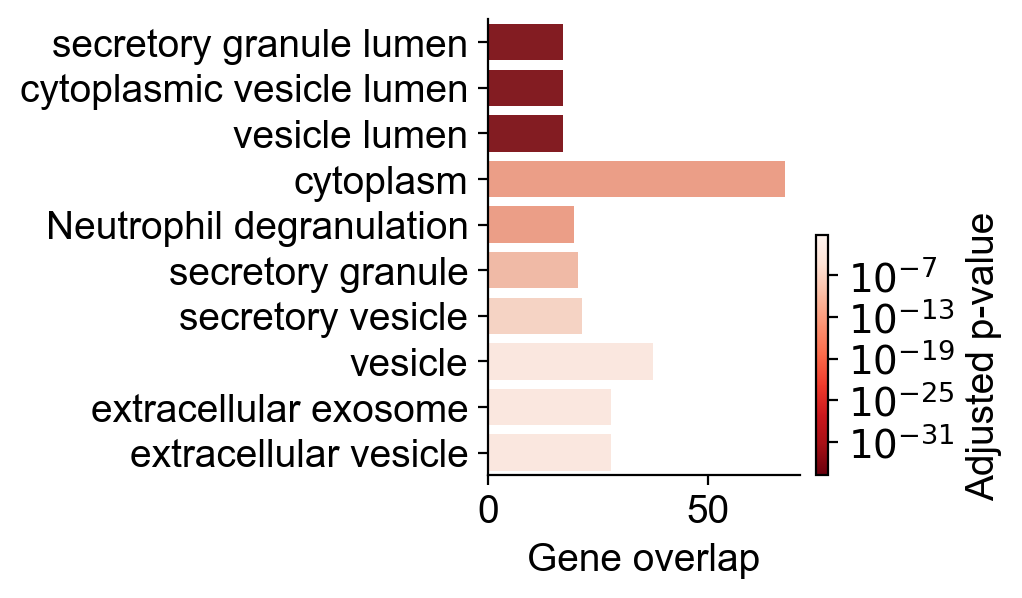

In [35]:
organism='hsapiens'
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')
print('calvaria vs bones ')
print('------------------')
gene_enrichment = gp.profile(organism=organism,
                             query=de_df_up["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrichment.to_csv(f"{RESULTS_DIR}/{bone}/de_calvaria_vs_bones_up.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, 
                     plot=True,
                     save=f"{SAVE_DIR}/{bone}/de_calvaria_vs_bones_up.pdf",
                    )


gene_enrichment = gp.profile(organism=organism,
                             query=de_df_down["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrichment.to_csv(f"{RESULTS_DIR}/{bone}/de_calvaria_vs_bones_down.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True,             
            save=f"{SAVE_DIR}/{bone}/de_calvaria_vs_bones_down.pdf",)

Vertebra vs rest
There are 2171 genes differentially expressed in Vertebra vs rest.

There are 22 genes differentially up regulated
There are 29 genes differentially down regulated


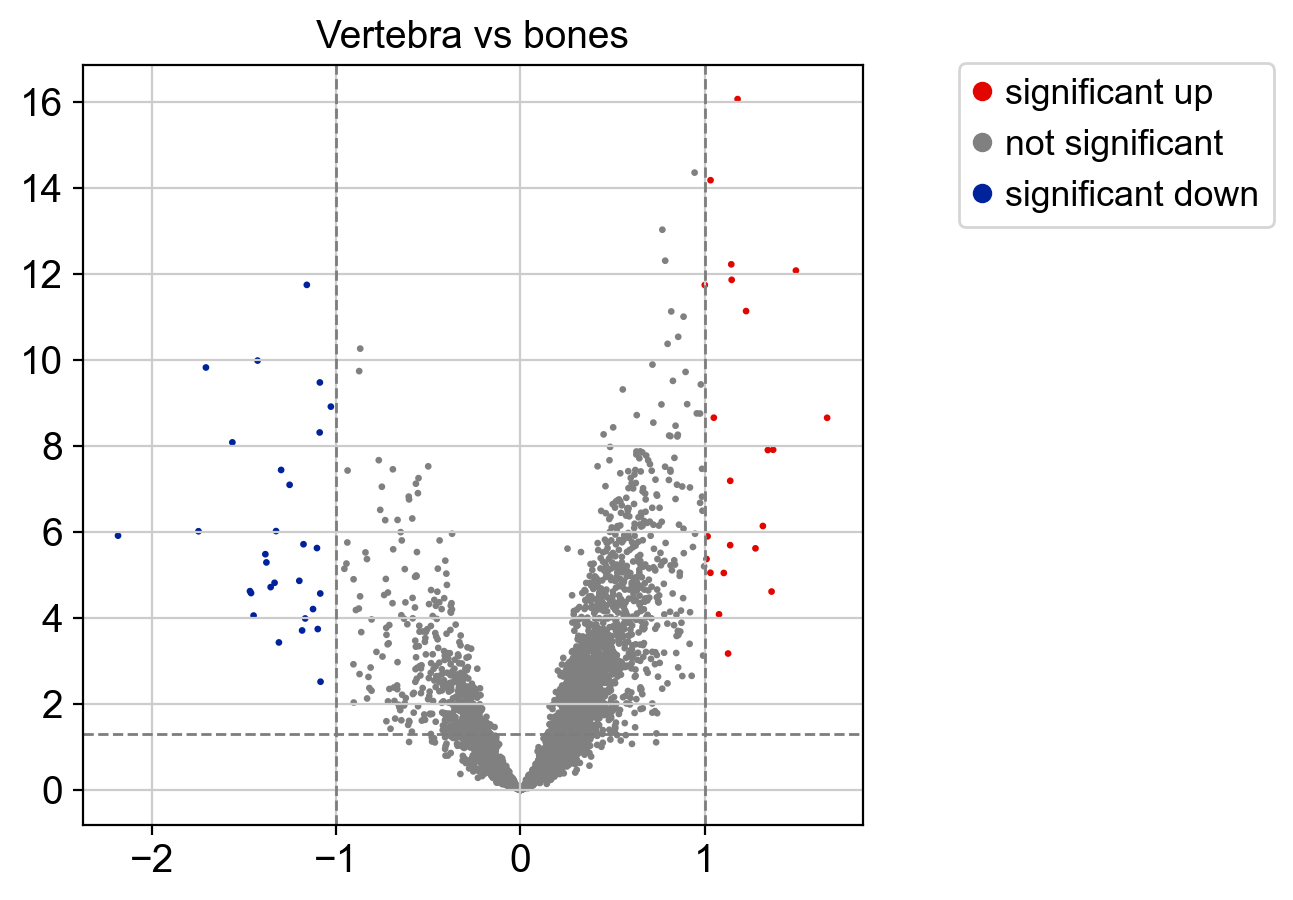

In [36]:
bone="Vertebra"
print(f'{bone} vs rest')

groupby="region"
ref_group=bone
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title=f'{bone} vs bones',
    save_fig=f"{SAVE_DIR}/{bone}/de_genes_{bone}_vs_bones.pdf",
    save_de_genes=f"{RESULTS_DIR}/{bone}/de_genes_{bone}_vs_bones.csv",
    return_de=True,
)

Vertebra vs rest
------------------


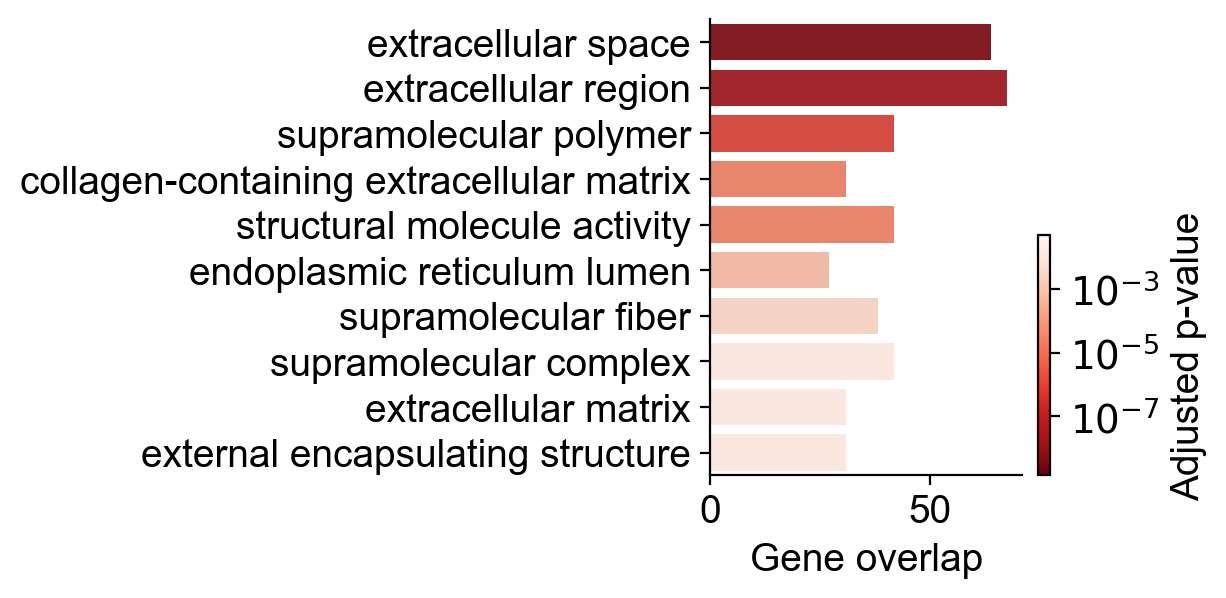

In [37]:
organism='hsapiens'
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')
print(f'{bone} vs rest')
print('------------------')
gene_enrichment = gp.profile(organism=organism,
                             query=de_df_up["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrichment.to_csv(f"{RESULTS_DIR}/{bone}/de_{bone}_vs_bones_up.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]


gene_enrichment = gp.profile(organism=organism,
                             query=de_df_down["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrichment.to_csv(f"{RESULTS_DIR}/{bone}/de_{bone}_vs_bones_down.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True,             
            save=f"{SAVE_DIR}/{bone}/de_{bone}_vs_bones_down.pdf",)

Pelvis vs rest
There are 3676 genes differentially expressed in Pelvis vs rest.

There are 193 genes differentially up regulated
There are 13 genes differentially down regulated


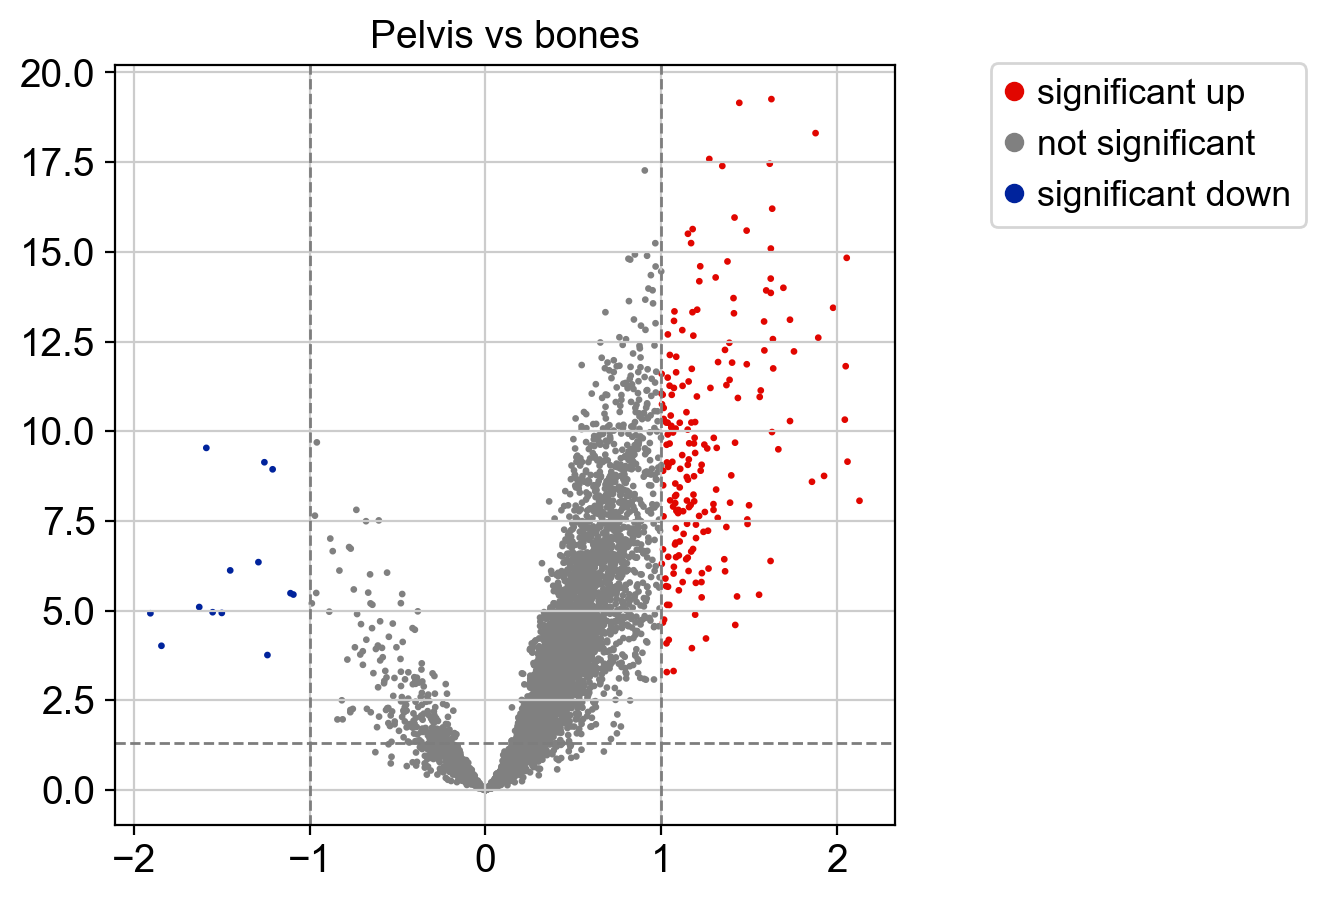

In [38]:
bone="Pelvis"
print(f'{bone} vs rest')

groupby="region"
ref_group=bone
de_df_sig, de_df_down, de_df_up = plot_volcano(
    adata=adata, 
    groupby=groupby, 
    ref_group=ref_group, 
    logfoldchanges_threshold=None, 
    pval_col=pvals_col,
    plot_volcano=True,
    title=f'{bone} vs bones',
    save_fig=f"{SAVE_DIR}/{bone}/de_genes_{bone}_vs_bones.pdf",
    save_de_genes=f"{RESULTS_DIR}/{bone}/de_genes_{bone}_vs_bones.csv",
    return_de=True,
)

Pelvis vs rest
------------------


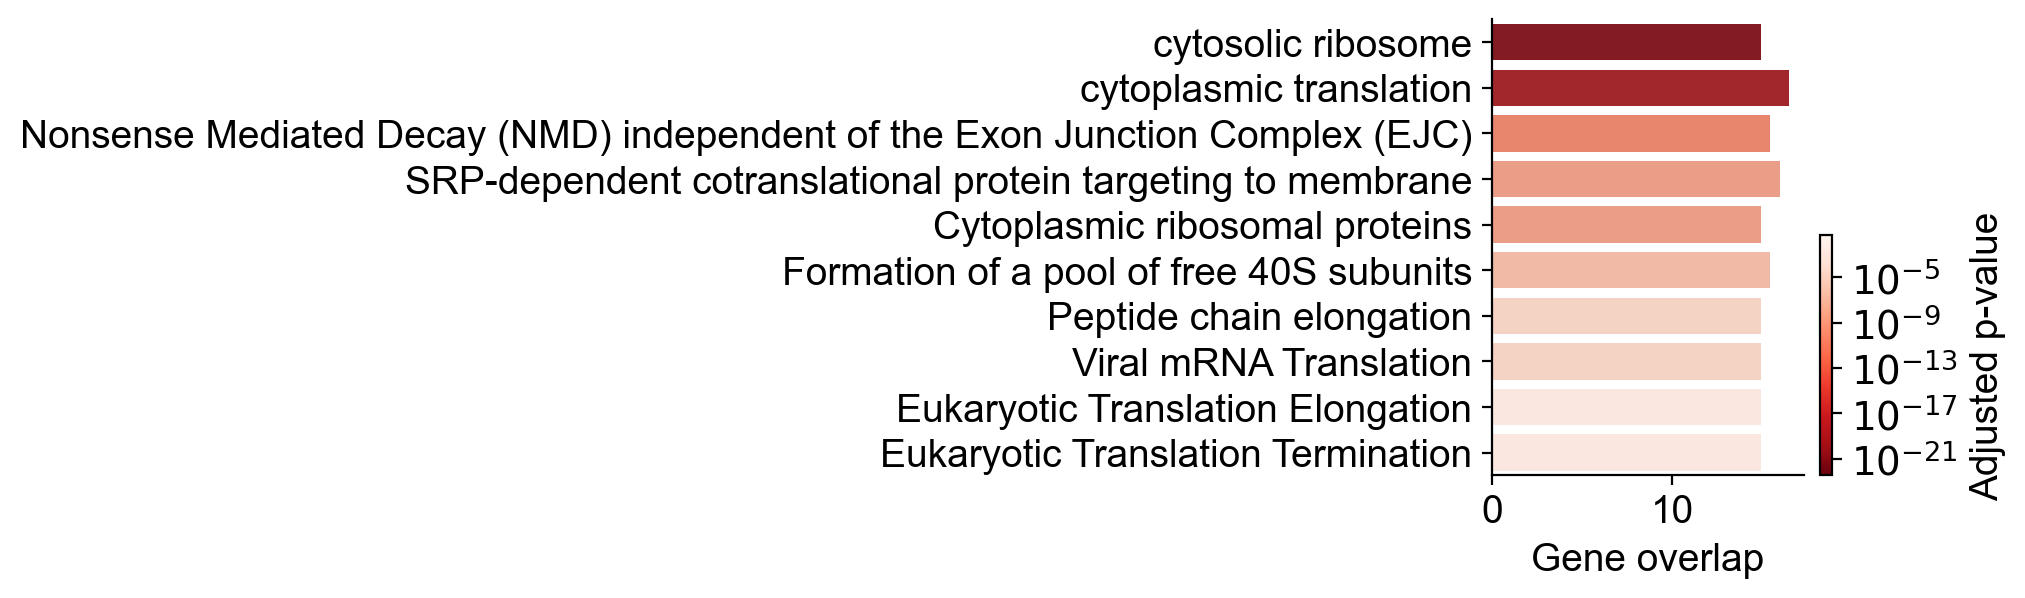

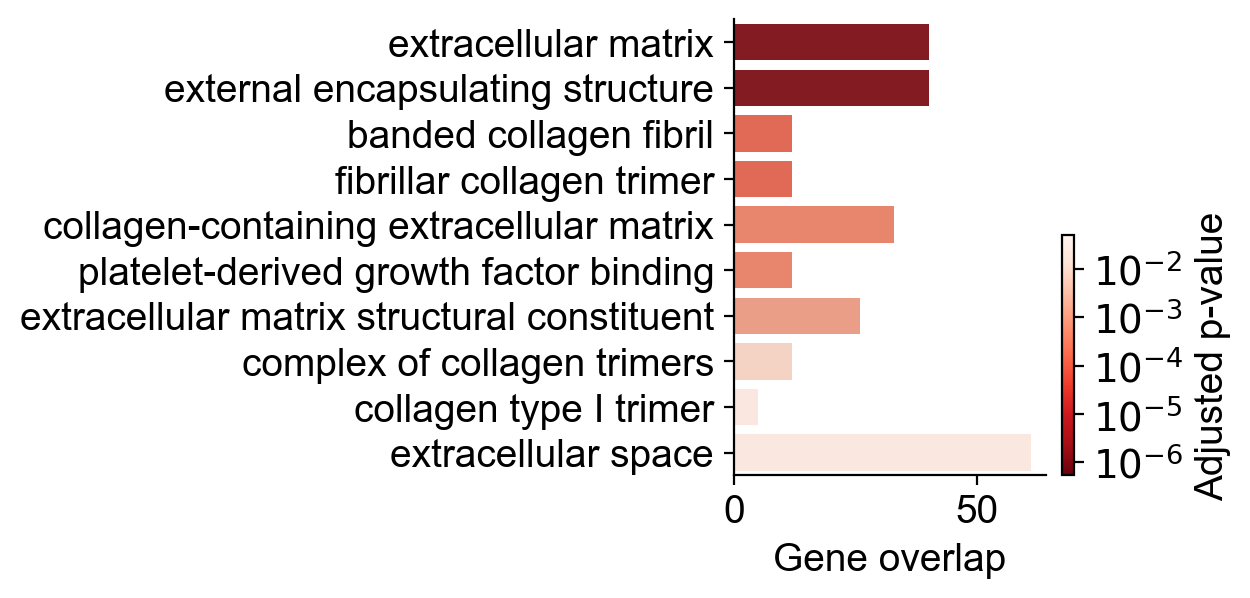

In [39]:
organism='hsapiens'
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')
print(f'{bone} vs rest')
print('------------------')
gene_enrichment = gp.profile(organism=organism,
                             query=de_df_up["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrichment.to_csv(f"{RESULTS_DIR}/{bone}/de_{bone}_vs_bones_up.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, 
                     plot=True,
                     save=f"{SAVE_DIR}/{bone}/de_{bone}_vs_bones_up.pdf",
                    )


gene_enrichment = gp.profile(organism=organism,
                             query=de_df_down["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrichment.to_csv(f"{RESULTS_DIR}/{bone}/de_{bone}_vs_bones_down.csv")
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True,             
            save=f"{SAVE_DIR}/{bone}/de_{bone}_vs_bones_down.pdf",)

Vertebra vs rest
There are 2171 genes differentially expressed in Vertebra vs rest.

There are 22 genes differentially up regulated
There are 29 genes differentially down regulated
Vertebra vs rest


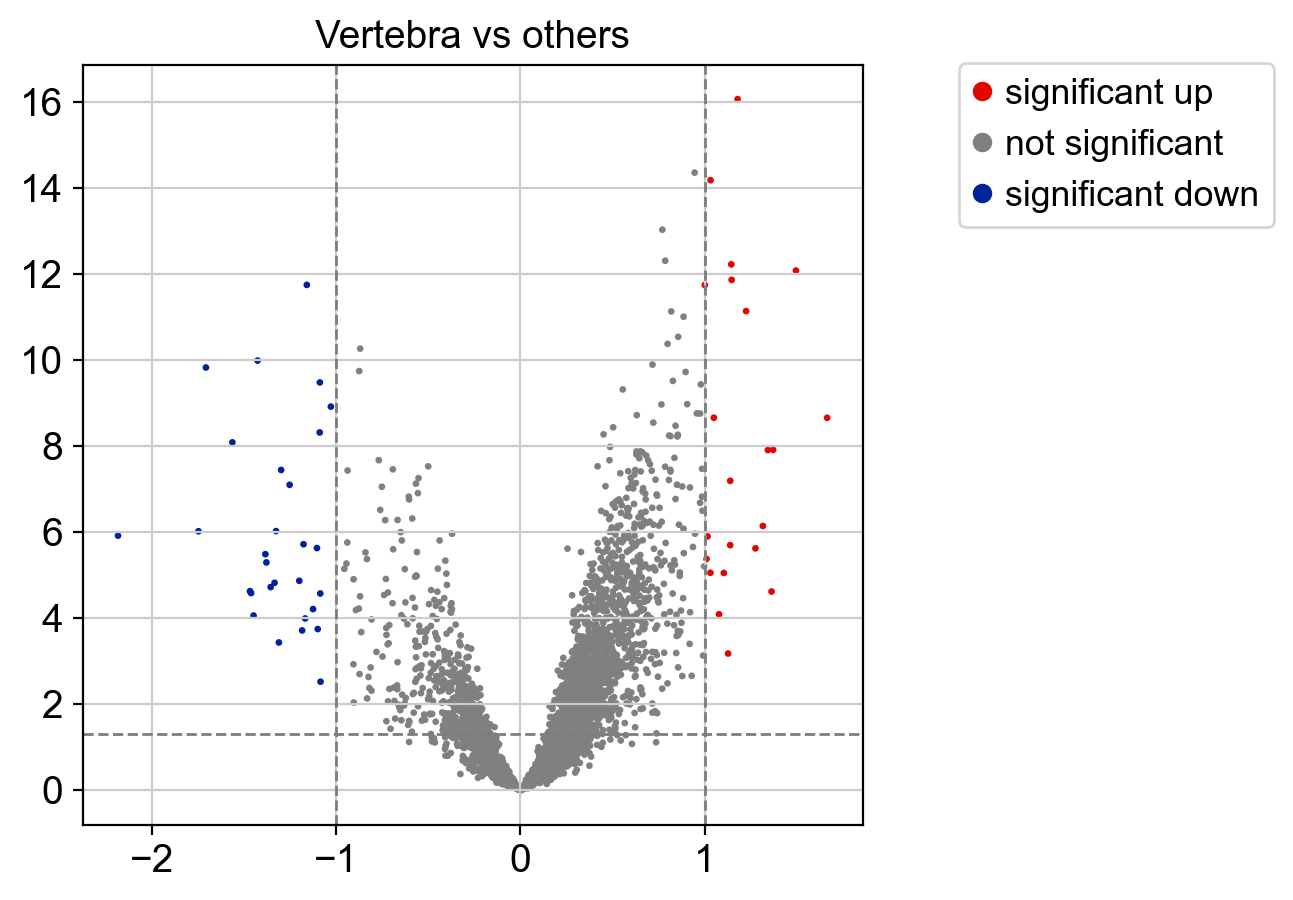

In [17]:
print('Vertebra vs rest')
de_df, de_genes = get_de_genes(
    adata, 
    groupby="region", 
    ref_group="Vertebra",
    n_genes=adata.var_names.size,
    logfoldchanges_threshold=None
)



print(f'There are {len(de_genes)} genes differentially expressed in Vertebra vs rest.')
print()
de_df_sig = de_df[de_df["diffexpressed"] == "YES"]

de_df_up = de_df_sig[de_df_sig["logfoldchanges"] > LOGFOLDCHANGE_THRESHOLD]
de_df_down = de_df_sig[de_df_sig["logfoldchanges"] < -LOGFOLDCHANGE_THRESHOLD]
print(f'There are {len(de_df_up)} genes differentially up regulated')
print(f'There are {len(de_df_down)} genes differentially down regulated')

de_df_up_vertebra = de_df_sig[de_df_sig["logfoldchanges"] > LOGFOLDCHANGE_THRESHOLD]
de_df_down_vertebra = de_df_sig[de_df_sig["logfoldchanges"] < -LOGFOLDCHANGE_THRESHOLD]

sign_genes = de_df_down["names"].tolist() +  de_df_up["names"].tolist()
genenames = {}
for gene in sign_genes:
    genenames[gene] = gene
print('Vertebra vs rest')
# plt.figure(figsize=(10,5))
fig = volcano(df=de_df, 
             lfc='logfoldchanges', 
             pv='pvals', 
             show=True, 
             dotsize=2,
             geneid="names", 
#                              genenames=genenames,

             lfc_thr=(LOGFOLDCHANGE_THRESHOLD, LOGFOLDCHANGE_THRESHOLD),
             sign_line=True,
             color=("#E10600FF", "grey", "#00239CFF"), 
             plotlegend=True, 
             axtickfontname='sans-serif',
             axlabelfontname='sans-serif',
             legendpos='upper right', 
             legendanchor=(1.55,1.025),
             title="Vertebra vs others",
             save="figures/final/volcano_vertebra_vs_other_20donors.pdf"
                             
                            )
df = pd.DataFrame()
df["genes"] = de_df_up["names"].tolist() + de_df_down["names"].tolist()
df["diffexpressed"] = np.append(np.full(len(de_df_up["names"].tolist()), "UP"),np.full(len(de_df_down["names"].tolist()), "DOWN"))

vertebra vs bones 
------------------


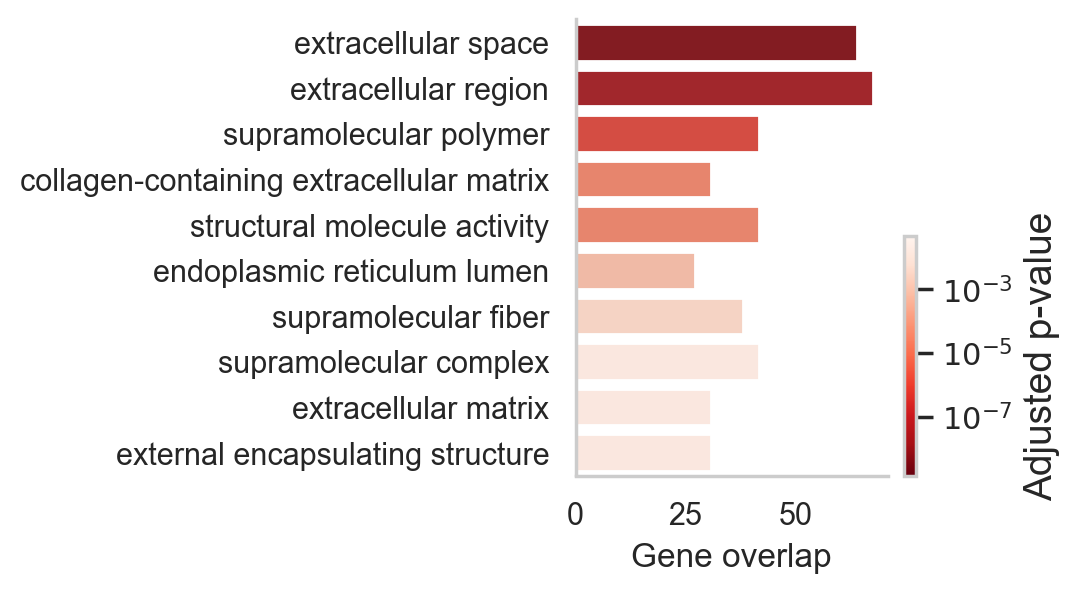

In [20]:
organism='hsapiens'
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')
print('vertebra vs bones ')
print('------------------')
gene_enrichment = gp.profile(organism=organism,
                             query=de_df_up["names"].values.tolist(),
                             no_evidences=False,
                            )


gene_enrichment = gp.profile(organism=organism,
                             query=de_df_down["names"].values.tolist(),
                             no_evidences=False,
                            )
gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True,
                     save=f"{SAVE_DIR}/de_vertebra_vs_bones_down.pdf")

Pelvis vs rest
There are 3676 genes differentially expressed in Pelvis vs rest.

There are 193 genes differentially up regulated
There are 13 genes differentially down regulated
Vertebra vs rest


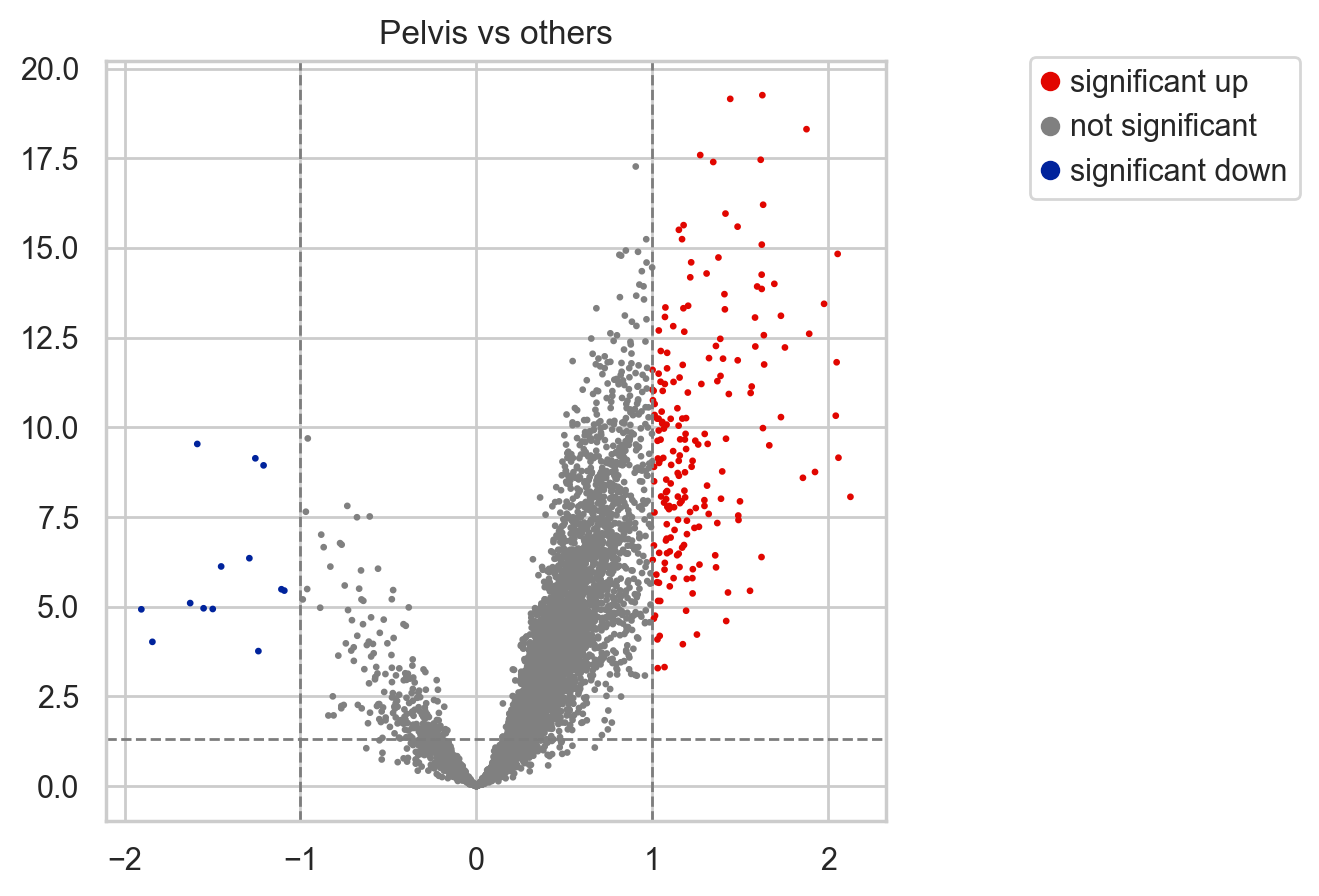

In [21]:
print('Pelvis vs rest')
de_df, de_genes = get_de_genes(
    adata, 
    groupby="region", 
    ref_group="Pelvis",
    n_genes=adata.var_names.size,
    logfoldchanges_threshold=None
)



print(f'There are {len(de_genes)} genes differentially expressed in Pelvis vs rest.')
print()
de_df_sig = de_df[de_df["diffexpressed"] == "YES"]

de_df_up = de_df_sig[de_df_sig["logfoldchanges"] > LOGFOLDCHANGE_THRESHOLD]
de_df_down = de_df_sig[de_df_sig["logfoldchanges"] < -LOGFOLDCHANGE_THRESHOLD]
print(f'There are {len(de_df_up)} genes differentially up regulated')
print(f'There are {len(de_df_down)} genes differentially down regulated')

de_df_up_pelvis = de_df_sig[de_df_sig["logfoldchanges"] > LOGFOLDCHANGE_THRESHOLD]
de_df_down_pelvis = de_df_sig[de_df_sig["logfoldchanges"] < -LOGFOLDCHANGE_THRESHOLD]

sign_genes = de_df_down["names"].tolist() +  de_df_up["names"].tolist()
genenames = {}
for gene in sign_genes:
    genenames[gene] = gene
print('Vertebra vs rest')
fig = volcano(df=de_df, 
             lfc='logfoldchanges', 
             pv='pvals', 
             show=True, 
             dotsize=2,
             geneid="names", 
#                              genenames=genenames,

             lfc_thr=(LOGFOLDCHANGE_THRESHOLD, LOGFOLDCHANGE_THRESHOLD),
             sign_line=True,
             color=("#E10600FF", "grey", "#00239CFF"), 
             plotlegend=True, 
             axtickfontname='sans-serif',
             axlabelfontname='sans-serif',
             legendpos='upper right', 
             legendanchor=(1.55,1.025),
             title="Pelvis vs others",
             save="figures/final/volcano_pelvis_vs_other_20donors.pdf"
                             
                            )
df = pd.DataFrame()
df["genes"] = de_df_up["names"].tolist() + de_df_down["names"].tolist()
df["diffexpressed"] = np.append(np.full(len(de_df_up["names"].tolist()), "UP"),np.full(len(de_df_down["names"].tolist()), "DOWN"))


pelvis vs bones 
------------------


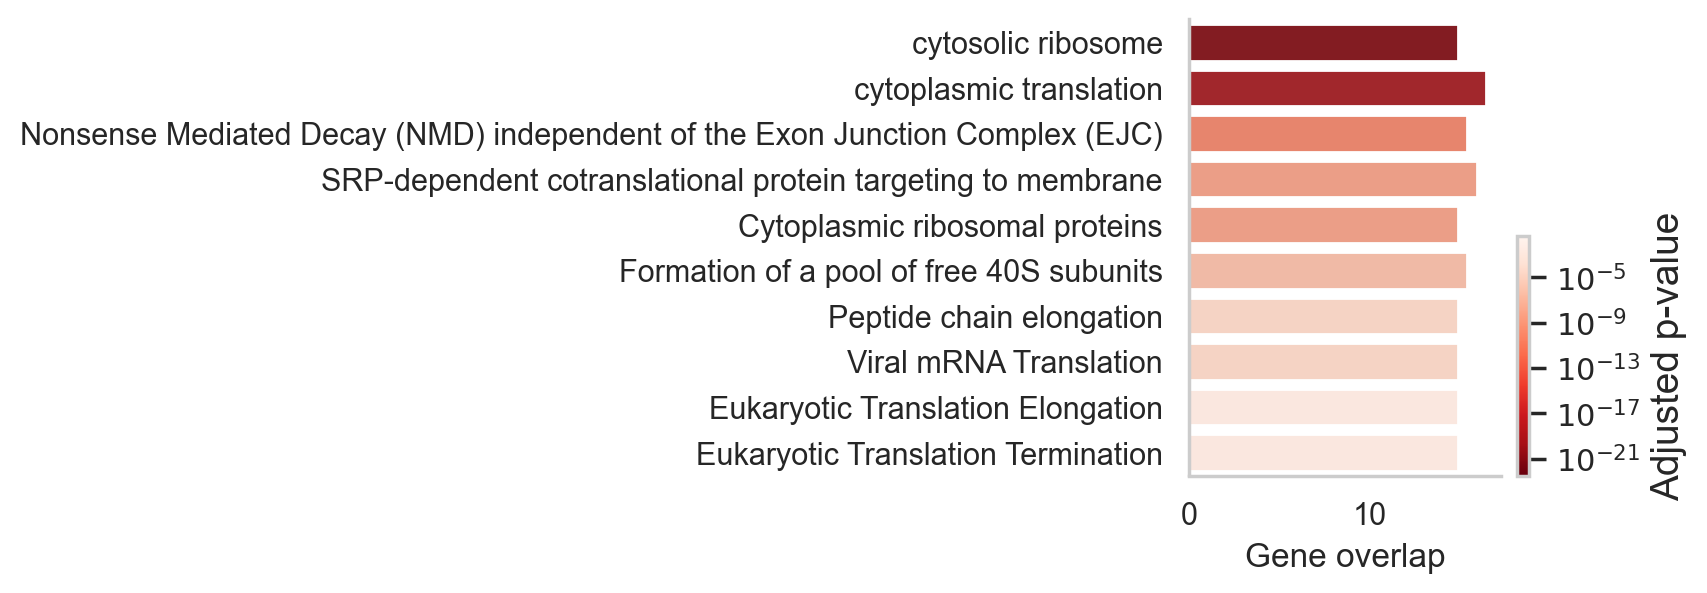

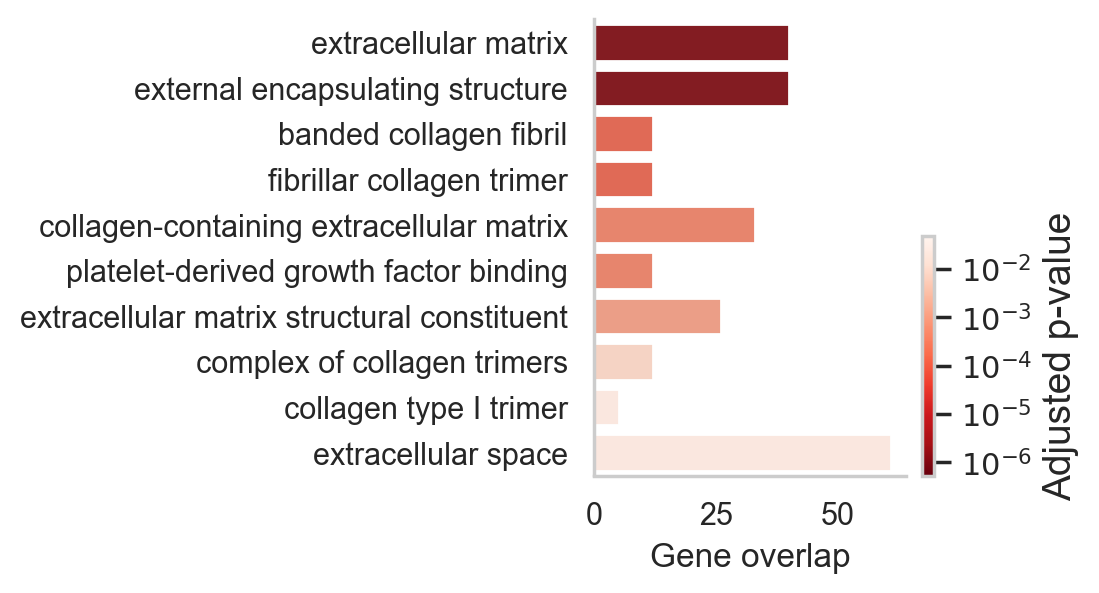

In [23]:
organism='hsapiens'
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')
print('pelvis vs bones ')
print('------------------')
gene_enrichment = gp.profile(organism=organism,
                             query=de_df_up["names"].values.tolist(),
                             no_evidences=False,
                            )

gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True,
                                 save=f"{SAVE_DIR}/de_pelvis_vs_bones_up.pdf",)


gene_enrichment = gp.profile(organism=organism,
                             query=de_df_down["names"].values.tolist(),
                             no_evidences=False,
                            )

gene_enrich_unique_results = gene_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
plot_gene_enrichment(gene_enrich_unique_results, plot=True,
                     save=f"{SAVE_DIR}/de_pelvis_vs_bones_down.pdf",)